In [30]:
# ==============================================================================
#  라이브러리 임포트
# ==============================================================================
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm # 로컬에서는 tqdm.notebook 대신 일반 tqdm 사용
from tqdm.contrib.concurrent import thread_map
import joblib

# skimage
from skimage.exposure import rescale_intensity, equalize_hist
from skimage.filters import gaussian
from skimage.restoration import denoise_bilateral
from skimage.util import img_as_ubyte
from skimage.feature import local_binary_pattern, hog
from skimage.transform import resize
from scipy import ndimage

# sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder,normalize
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
# joblib (병렬 처리를 위해)
from joblib import Parallel, delayed

# faiss (KNN 가속화를 위해)
import faiss

# 데이터 관련 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns
import matplotlib.pyplot as plt

# Ensemble
from Ensemble import EnsembleFaissKNN

DATASET_BASE_PATH = "C:/Users/bvb09/.cache/kagglehub/datasets/mikhailma/test-dataset/versions/1/Google_Recaptcha_V2_Images_Dataset"
#DATASET_BASE_PATH = "C:/Users/bvb09/.cache/kagglehub/datasets/refined/test-dataset/versions/1/Google_Recaptcha_V2_Images_Dataset"

print("✔ 모든 라이브러리 임포트 완료!")

✔ 모든 라이브러리 임포트 완료!


In [31]:
# ==============================================================================
#  데이터 로드 함수
# ==============================================================================

# 이미지 로드 함수
def load_images_from_folder(base_path, img_size=(120, 120)):
    images = []
    labels = []
    image_folder_path = os.path.join(base_path, 'images')
    
    if not os.path.exists(image_folder_path):
        raise FileNotFoundError(f"이미지 폴더를 찾을 수 없습니다: {image_folder_path}\n"
                                f"DATASET_BASE_PATH를 올바르게 설정했는지 확인해주세요.")

    for label_name in tqdm(os.listdir(image_folder_path), desc="폴더 로드 중"):
        label_path = os.path.join(image_folder_path, label_name)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        images.append(img)
                        labels.append(label_name)
                    else:
                        print(f"경고: {img_path} 이미지를 로드할 수 없습니다.")
                except Exception as e:
                    print(f"경고: {img_path} 로딩 중 오류 발생 - {e}")
    return pd.DataFrame({'image_data': images, 'label': labels})

def visualize_features(X_feats, y_labels, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    else:
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42)

    X_reduced = reducer.fit_transform(X_feats)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_labels, cmap='tab20', s=10, alpha=0.7)
    plt.title(f'Feature Distribution via {method.upper()}')
    plt.colorbar(scatter, ticks=range(len(set(y_labels))))
    plt.tight_layout()
    plt.show()

In [32]:
# === Pre‑ & Post‑processing utilities (updated 2025‑06‑03) ===
from skimage.feature import local_binary_pattern, hog as sk_hog

def preprocess_image(img_bgr, use_hog=True): # 인자 이름을 img_path에서 img_bgr로 변경하거나, 기존 img 그대로 사용
    """이미지(NumPy 배열)를 받아 특징 벡터를 반환합니다.
    · Color histograms (B, G, R) – 256 bins each, normalized
    · Color‑channel uniform LBP histograms – 9 bins each
    · (optional) Gray‑scale HOG (16×16 cell, 2×2 block, 9 orient)
    모든 하위 벡터는 연결하기 전에 ℓ1‑정규화됩니다.
    """
    # 1) 이미 로드된 이미지를 사용, cv2.imread 호출 제거
    if img_bgr is None:
        raise ValueError("입력 이미지가 None입니다.")

    # LAB-CLAHE를 통한 대비 향상
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    img_bgr = cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2BGR)

    # 2) 양방향 노이즈 제거 (가장자리 보존)
    img_bgr = cv2.bilateralFilter(img_bgr, d=7, sigmaColor=75, sigmaSpace=75)

    # 3) 컬러 히스토그램 (ℓ1‑정규화)
    hist_feats = []
    for ch in cv2.split(img_bgr):      # B, G, R
        hist = cv2.calcHist([ch], [0], None, [256], [0, 256]).flatten()
        hist /= hist.sum() if hist.sum() != 0 else 1.0
        hist_feats.append(hist)
    hist_feats = np.concatenate(hist_feats)

    # 4) 채널별 Uniform‑LBP (P=8, R=1 → 9‑bin)
    lbp_feats = []
    for ch in cv2.split(img_bgr):
        lbp = local_binary_pattern(ch, 8, 1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        hist = hist.astype('float32')
        hist /= (hist.sum() + 1e-7)
        lbp_feats.append(hist)
    lbp_feats = np.concatenate(lbp_feats)

    # 5) 그레이 스케일 HOG
    hog_feat = np.array([], dtype='float32')
    if use_hog:
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        hog_feat = sk_hog(gray,
                          orientations=9,
                          pixels_per_cell=(16, 16),
                          cells_per_block=(2, 2),
                          block_norm='L2-Hys',
                          visualize=False,
                          feature_vector=True)
        hog_feat = hog_feat.astype('float32')
        hog_norm = np.linalg.norm(hog_feat, ord=1)
        hog_feat = hog_feat / hog_norm if hog_norm != 0 else hog_feat

    # 6) 모든 부분 연결
    features = np.concatenate([hist_feats, lbp_feats, hog_feat]).astype('float32')
    return features


In [33]:
# ==============================================================================
#  피쳐 추출 함수
# ==============================================================================

def build_sift_vocabulary(images, n_clusters):
    sift = cv2.SIFT_create()
    all_descriptors = []

    for img in tqdm(images, desc="Extracting SIFT descriptors for vocab"):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img
        _, descriptors = sift.detectAndCompute(gray, None)
        if descriptors is not None:
            all_descriptors.append(descriptors)

    all_descriptors = np.vstack(all_descriptors)  # (N, 128)
    if len(all_descriptors) == 0:
        raise ValueError("SIFT descriptors를 추출할 수 없습니다. 이미지가 손상되었거나 불러오기에 실패했을 수 있습니다.")

    print(f"✔ 총 {all_descriptors.shape[0]}개의 SIFT descriptors 추출됨.")

    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=2048, n_init='auto')
    kmeans.fit(all_descriptors)
    return kmeans

def extract_bovw_sift_features(image_gray, vocabulary_kmeans):
    
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image_gray, None)

    if descriptors is None or descriptors.shape[0] == 0:
        # Return a zero vector of the size of the vocabulary if no descriptors found
        return np.zeros(vocabulary_kmeans.n_clusters)

    # Predict the cluster for each descriptor
    visual_words = vocabulary_kmeans.predict(descriptors)

    # Create a histogram of visual words
    bovw_histogram = np.zeros(vocabulary_kmeans.n_clusters)
    for word_index in visual_words:
        bovw_histogram[word_index] += 1

    # Normalize the histogram
    bovw_histogram = bovw_histogram / (np.sum(bovw_histogram) + 1e-7)
    return bovw_histogram

# SIFT (Scale-Invariant Feature Transform) - 기존과 동일
def extract_sift_descriptors(image_gray):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image_gray, None)
    if descriptors is None:
        return np.zeros(128)
    return np.mean(descriptors, axis=0) if descriptors.shape[0] > 0 else np.zeros(128)

# Laws' Texture Energy - 기존과 동일
def extract_laws_energy_features(image_gray, window_size=15):
    L5 = np.array([1, 4, 6, 4, 1], dtype=np.float32)
    E5 = np.array([-1, -2, 0, 2, 1], dtype=np.float32)
    S5 = np.array([-1, 0, 2, 0, -1], dtype=np.float32)
    W5 = np.array([-1, 2, 0, -2, 1], dtype=np.float32)
    R5 = np.array([1, -4, 6, -4, 1], dtype=np.float32)
    kernels = [L5, E5, S5, W5, R5]

    energy_features = []
    if image_gray.dtype == np.uint8:
        image_gray = image_gray.astype(np.float32)

    for k1 in kernels:
        for k2 in kernels:
            kernel = np.outer(k1, k2)
            filtered = ndimage.convolve(image_gray, kernel, mode='reflect')
            energy = np.abs(filtered)
            summed = cv2.boxFilter(energy, ddepth=-1, ksize=(window_size, window_size), normalize=False)
            energy_features.append(summed.mean())

    return np.array(energy_features, dtype=np.float32)

def extract_bovw_sift_features(image_gray, vocabulary_kmeans):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image_gray, None)

    if descriptors is None or descriptors.shape[0] == 0:
        # Return a zero vector of the size of the vocabulary if no descriptors found
        return np.zeros(vocabulary_kmeans.n_clusters)

    # Predict the cluster for each descriptor using the MiniBatchKMeans model
    visual_words = vocabulary_kmeans.predict(descriptors) # <--- THIS IS THE FIX

    # Create a histogram of visual words
    bovw_histogram = np.zeros(vocabulary_kmeans.n_clusters)
    for word_index in visual_words:
        bovw_histogram[word_index] += 1

    # Normalize the histogram
    bovw_histogram = bovw_histogram / (np.sum(bovw_histogram) + 1e-7)
    return bovw_histogram

def extract_features(image, sift_vocabulary, use_hog=True):
    # Base features (color hist/LBP/HOG)
    base_feats = preprocess_image(image, use_hog=use_hog)

    # SIFT BoVW
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    sift_feats = extract_bovw_sift_features(gray, sift_vocabulary)

    # Laws
    laws_feats = extract_laws_energy_features(gray)

    # Concatenate + L2 norm
    feat_vec = np.concatenate([base_feats, laws_feats, sift_feats]).astype('float32')
    feat_vec /= (np.linalg.norm(feat_vec) + 1e-7)
    return feat_vec

print("✔ 특징 추출 함수 정의 완료")

✔ 특징 추출 함수 정의 완료


In [34]:
# ==============================================================================
#  분류 모델 및 학습/평가 함수
# ==============================================================================
# 유클리드 거리 기반 Faiss KNN 학습 (수정됨)
def train_faiss_knn_euclidean(X_train, y_train, n_neighbors=6):
    # 유클리드 거리 기반에서는 데이터 정규화가 필요 없습니다.
    # X_train = normalize(X_train, axis=1) # 이 줄을 주석 처리하거나 삭제합니다.
    X_train = X_train.astype(np.float32)
    D = X_train.shape[1]

    # Inner Product (IP) 대신 L2 거리를 사용하는 인덱스를 생성합니다.
    index = faiss.IndexFlatL2(D) # <-- 변경된 부분
    index.add(X_train)

    return index, y_train, n_neighbors

# 유클리드 거리 기반 Faiss KNN 예측 (수정됨)
def predict_faiss_knn_euclidean(index, y_train_labels, n_neighbors, X_test):
    # 유클리드 거리 기반에서는 테스트 데이터 정규화도 필요 없습니다.
    # X_test = normalize(X_test, axis=1) # 이 줄을 주석 처리하거나 삭제합니다.
    X_test = X_test.astype(np.float32)

    # search 결과는 D (거리)와 I (인덱스)입니다.
    # L2 거리이므로 거리가 작을수록 가까운 것입니다.
    distances, indices = index.search(X_test, n_neighbors) # <-- 이름 변경 (similarities -> distances)

    y_pred = []
    for i in range(len(X_test)):
        neighbor_labels = y_train_labels[indices[i]]
        # 거리 기반이므로 가장 가까운 이웃들의 레이블을 통해 다수결 투표
        unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
        predicted_label = unique_labels[np.argmax(counts)]
        y_pred.append(predicted_label)
    return np.array(y_pred)

# test() 함수
def test(model_tuple, X_test, y_test, average='weighted'):
    faiss_index, y_train_labels, n_neighbors = model_tuple
    
    print(f"  ▶ KNN 예측 중 (Faiss 사용, k={n_neighbors})...")
    y_pred = predict_faiss_knn_cosine(faiss_index, y_train_labels, n_neighbors, X_test)
    print("  ✔ 예측 완료.")
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average, zero_division=0)
    rec  = recall_score(y_test, y_pred, average=average, zero_division=0)
    print(f"[Test Accuracy] {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    return y_pred
print("✔ 분류 모델 및 학습/평가 함수 정의 완료 (Faiss 적용).")

✔ 분류 모델 및 학습/평가 함수 정의 완료 (Faiss 적용).


폴더 로드 중: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

✔ 총 10179개의 이미지 로드 완료.
✔ 라벨 인코딩 완료. 클래스: ['Bicycle' 'Bridge' 'Bus' 'Car' 'Chimney' 'Crosswalk' 'Hydrant'
 'Motorcycle' 'Palm' 'Traffic Light']


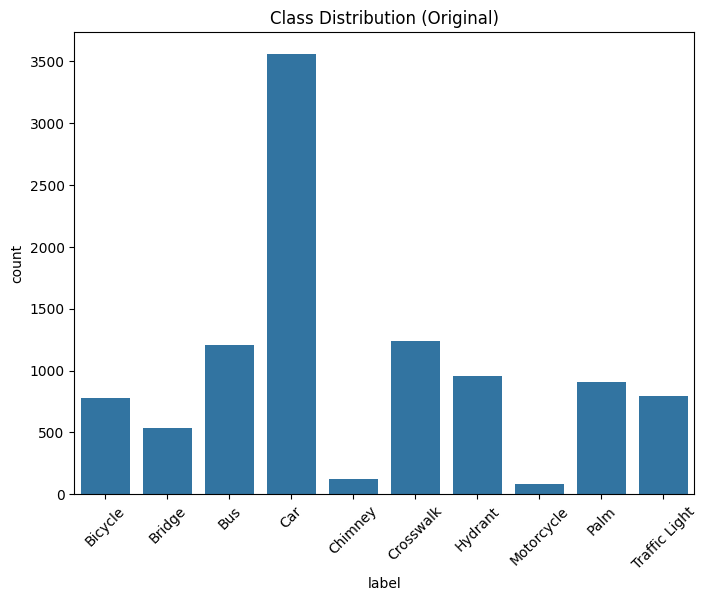

✔ 언더샘플링 및 오버샘플링 완료. 총 샘플 수: 9312


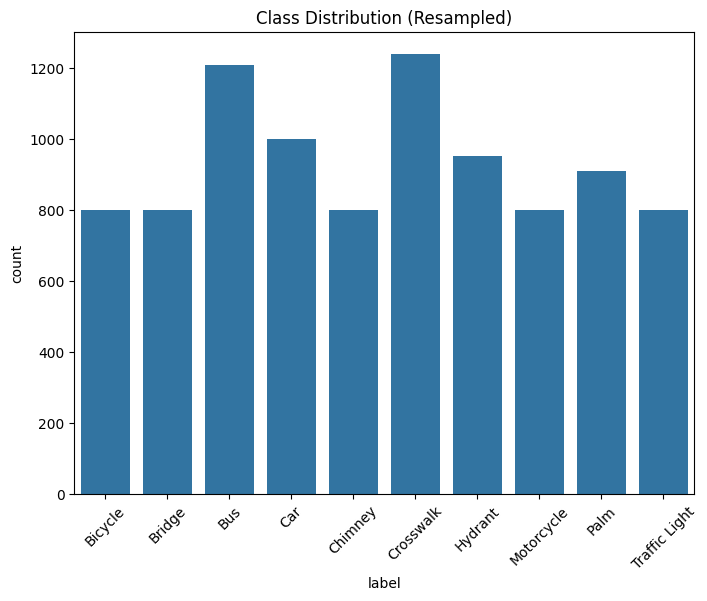

✔ Stratified K-Fold 설정 완료 (5-Fold)


In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns

# ==============================================================================
#  데이터 로드
# ==============================================================================
# 1. 이미지 로드
try:
    images_df = load_images_from_folder(DATASET_BASE_PATH)
    print(f"✔ 총 {len(images_df)}개의 이미지 로드 완료.")
except FileNotFoundError as e:
    print(f"오류: {e}")
    exit()

# 2. 라벨 인코딩
le = LabelEncoder()
images_df['label_encoded'] = le.fit_transform(images_df['label'])
print(f"✔ 라벨 인코딩 완료. 클래스: {le.classes_}")

# 3. 클래스 분포 시각화 (원본)
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=images_df)
plt.xticks(rotation=45)
plt.title("Class Distribution (Original)")
plt.show()

# 4. 언더샘플링
X = np.arange(len(images_df)).reshape(-1, 1)
y = images_df['label_encoded'].values

# 과다 클래스(Car)만 줄임
car_class = le.transform(['Car'])[0]
undersample_target = {car_class: 1000}  # Car만 1000개로 제한
rus = RandomUnderSampler(sampling_strategy=undersample_target, random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)

# 언더샘플링 적용된 데이터 추출
df_rus = images_df.iloc[X_rus.flatten()].copy()
df_rus['label_encoded'] = y_rus

# 5. 오버샘플링 (800개 미만 클래스 보완)
class_counts = df_rus['label_encoded'].value_counts()
minority_classes = {cls: 800 for cls, count in class_counts.items() if count < 800}

ros = RandomOverSampler(sampling_strategy=minority_classes, random_state=42)
X_ros, y_ros = ros.fit_resample(np.arange(len(df_rus)).reshape(-1, 1), df_rus['label_encoded'])

# 최종 리샘플링 결과
images_df_resampled = df_rus.iloc[X_ros.flatten()].reset_index(drop=True)
images_df_resampled['label_encoded'] = y_ros
images_df_resampled['label'] = le.inverse_transform(y_ros)

print(f"✔ 언더샘플링 및 오버샘플링 완료. 총 샘플 수: {len(images_df_resampled)}")

# 6. 클래스 분포 시각화 (리샘플링 후)
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=images_df_resampled)
plt.xticks(rotation=45)
plt.title("Class Distribution (Resampled)")
plt.show()

# 7. Stratified K-Fold 준비
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("✔ Stratified K-Fold 설정 완료 (5-Fold)")

In [36]:
print("\n=== SIFT 시각 단어 사전 구축 시작 ===")
# 이 사전은 K-Fold 교차 검증의 모든 폴드에서 학습 및 테스트 특징 추출에 사용됩니다.
sift_bovw_vocabulary = build_sift_vocabulary(images_df_resampled['image_data'].values, n_clusters=512)
print("✔ SIFT 시각 단어 사전 구축 완료.")
joblib.dump(sift_bovw_vocabulary, "sift_bovw_vocabulary.pkl")


=== SIFT 시각 단어 사전 구축 시작 ===


Extracting SIFT descriptors for vocab: 100%|██████████| 9312/9312 [00:56<00:00, 164.33it/s]


✔ 총 1200407개의 SIFT descriptors 추출됨.
✔ SIFT 시각 단어 사전 구축 완료.


['sift_bovw_vocabulary.pkl']

모델 저장 기본 경로: c:\Users\bvb09\OneDrive\바탕 화면\컴퓨터비전\my\vision_challenge\image_classification_models

=== 5-Fold 교차 검증 시작 ===


Processing Folds:   0%|          | 0/5 [00:00<?, ?it/s]


=== Fold 0 ===
[Fold 0] ▶ Original Train: 7449개, Original Test: 1863개
[Fold 0] ▶ Resampled Train: 7449개, Test: 1863개
  ▶ Train feature extraction (Fold 0)...


  Extracting Train Features (Fold 0): 100%|██████████| 7449/7449 [03:23<00:00, 36.58it/s]


  ✔ Train feature extraction complete for Fold 0. Feature Shape: (7449, 2628)
  ✔ Faiss KNN 모델 학습 완료 (Fold 0).
  ▶ Test feature extraction (Fold 0)...


  Extracting Test Features (Fold 0): 100%|██████████| 1863/1863 [00:46<00:00, 40.32it/s]


  ✔ Test feature extraction complete for Fold 0. Feature Shape: (1863, 2628)
  ▶ KNN 예측 중 (Faiss 사용, k=5)...
  ✔ 예측 완료.
[Test Accuracy] 0.4718
               precision    recall  f1-score   support

      Bicycle       0.23      0.29      0.25       160
       Bridge       0.38      0.39      0.39       160
          Bus       0.41      0.48      0.44       242
          Car       0.24      0.23      0.24       200
      Chimney       0.84      0.98      0.90       160
    Crosswalk       0.53      0.45      0.49       248
      Hydrant       0.57      0.49      0.53       191
   Motorcycle       0.72      1.00      0.84       160
         Palm       0.37      0.31      0.34       182
Traffic Light       0.33      0.17      0.22       160

     accuracy                           0.47      1863
    macro avg       0.46      0.48      0.46      1863
 weighted avg       0.46      0.47      0.46      1863



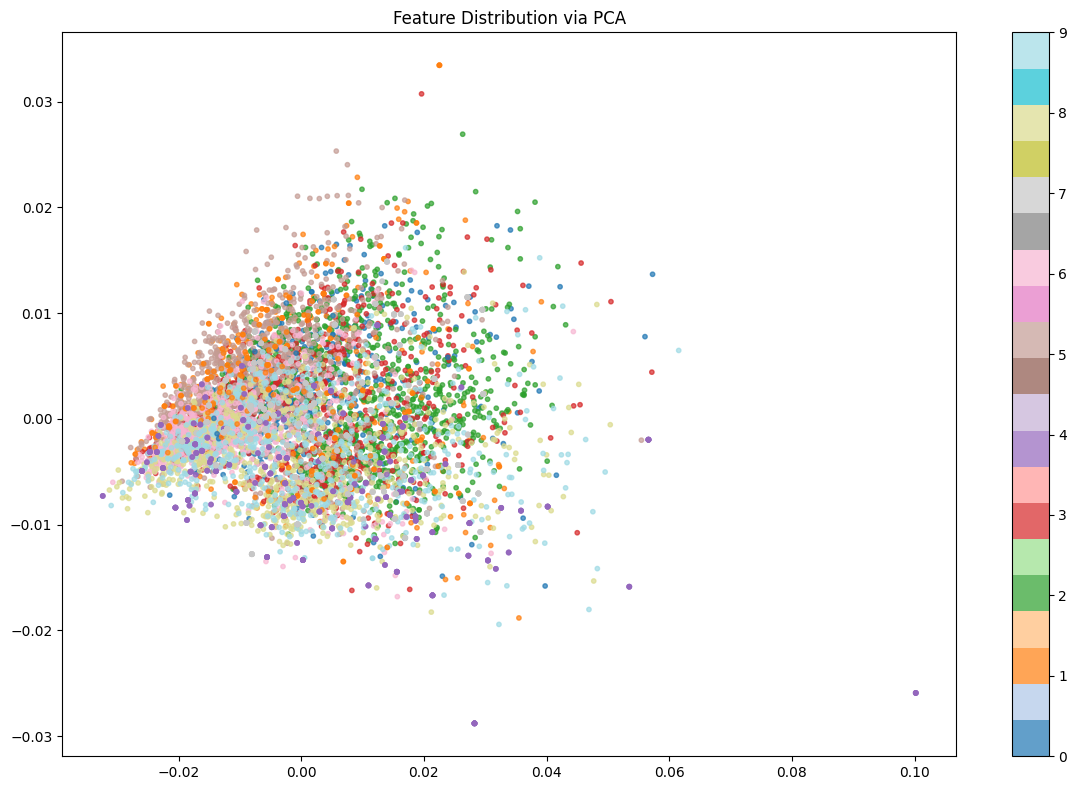

Processing Folds:  20%|██        | 1/5 [04:11<16:45, 251.48s/it]

✔ Fold 0 Faiss Index and parameters saved to 'image_classification_models\knn_faiss_folds'.

=== Fold 1 ===
[Fold 1] ▶ Original Train: 7449개, Original Test: 1863개
[Fold 1] ▶ Resampled Train: 7449개, Test: 1863개
  ▶ Train feature extraction (Fold 1)...


  Extracting Train Features (Fold 1): 100%|██████████| 7449/7449 [03:18<00:00, 37.53it/s]


  ✔ Train feature extraction complete for Fold 1. Feature Shape: (7449, 2628)
  ✔ Faiss KNN 모델 학습 완료 (Fold 1).
  ▶ Test feature extraction (Fold 1)...


  Extracting Test Features (Fold 1): 100%|██████████| 1863/1863 [00:47<00:00, 39.63it/s]


  ✔ Test feature extraction complete for Fold 1. Feature Shape: (1863, 2628)
  ▶ KNN 예측 중 (Faiss 사용, k=5)...
  ✔ 예측 완료.
[Test Accuracy] 0.4702
               precision    recall  f1-score   support

      Bicycle       0.26      0.34      0.29       160
       Bridge       0.37      0.49      0.42       160
          Bus       0.40      0.45      0.43       242
          Car       0.27      0.27      0.27       200
      Chimney       0.81      1.00      0.89       160
    Crosswalk       0.58      0.40      0.48       248
      Hydrant       0.51      0.47      0.49       190
   Motorcycle       0.71      0.95      0.82       160
         Palm       0.40      0.30      0.34       183
Traffic Light       0.32      0.16      0.21       160

     accuracy                           0.47      1863
    macro avg       0.46      0.48      0.46      1863
 weighted avg       0.46      0.47      0.46      1863



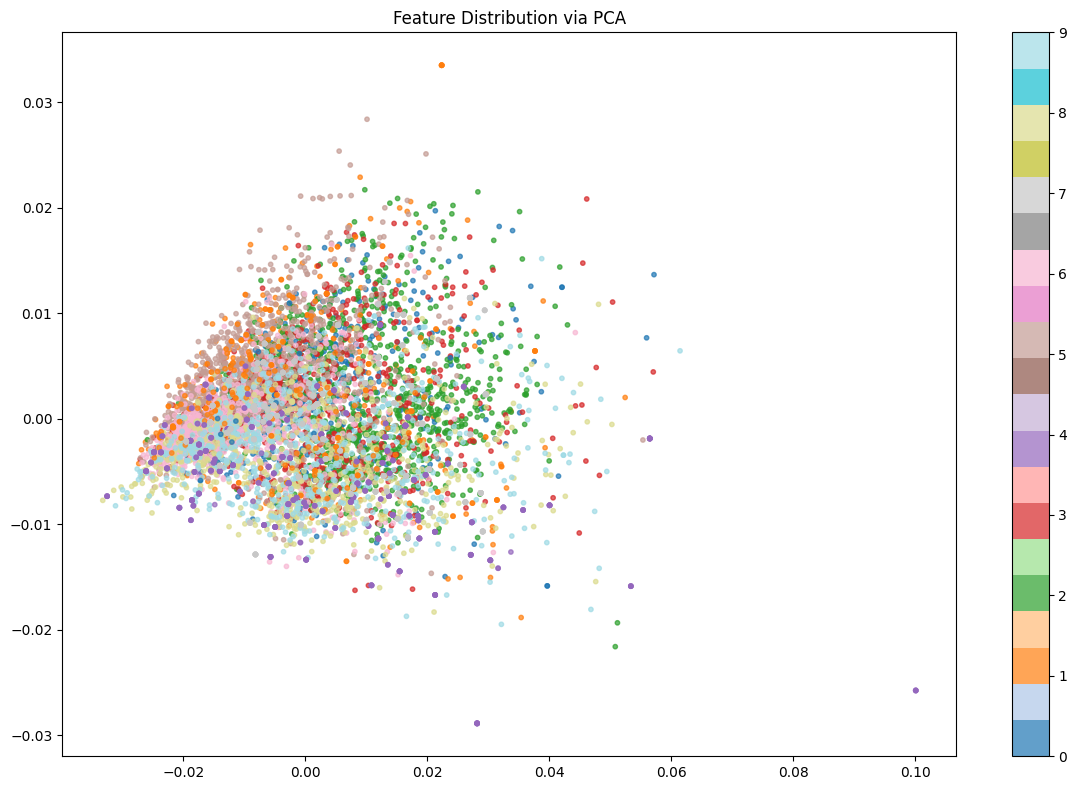

Processing Folds:  40%|████      | 2/5 [08:18<12:26, 248.85s/it]

✔ Fold 1 Faiss Index and parameters saved to 'image_classification_models\knn_faiss_folds'.

=== Fold 2 ===
[Fold 2] ▶ Original Train: 7450개, Original Test: 1862개
[Fold 2] ▶ Resampled Train: 7450개, Test: 1862개
  ▶ Train feature extraction (Fold 2)...


  Extracting Train Features (Fold 2): 100%|██████████| 7450/7450 [03:29<00:00, 35.62it/s]


  ✔ Train feature extraction complete for Fold 2. Feature Shape: (7450, 2628)
  ✔ Faiss KNN 모델 학습 완료 (Fold 2).
  ▶ Test feature extraction (Fold 2)...


  Extracting Test Features (Fold 2): 100%|██████████| 1862/1862 [00:48<00:00, 38.31it/s]


  ✔ Test feature extraction complete for Fold 2. Feature Shape: (1862, 2628)
  ▶ KNN 예측 중 (Faiss 사용, k=5)...
  ✔ 예측 완료.
[Test Accuracy] 0.4834
               precision    recall  f1-score   support

      Bicycle       0.21      0.29      0.25       160
       Bridge       0.43      0.50      0.46       160
          Bus       0.40      0.48      0.44       242
          Car       0.30      0.22      0.25       200
      Chimney       0.80      0.94      0.87       160
    Crosswalk       0.57      0.47      0.51       248
      Hydrant       0.59      0.51      0.55       190
   Motorcycle       0.72      1.00      0.84       160
         Palm       0.41      0.36      0.38       182
Traffic Light       0.31      0.14      0.20       160

     accuracy                           0.48      1862
    macro avg       0.47      0.49      0.47      1862
 weighted avg       0.47      0.48      0.47      1862



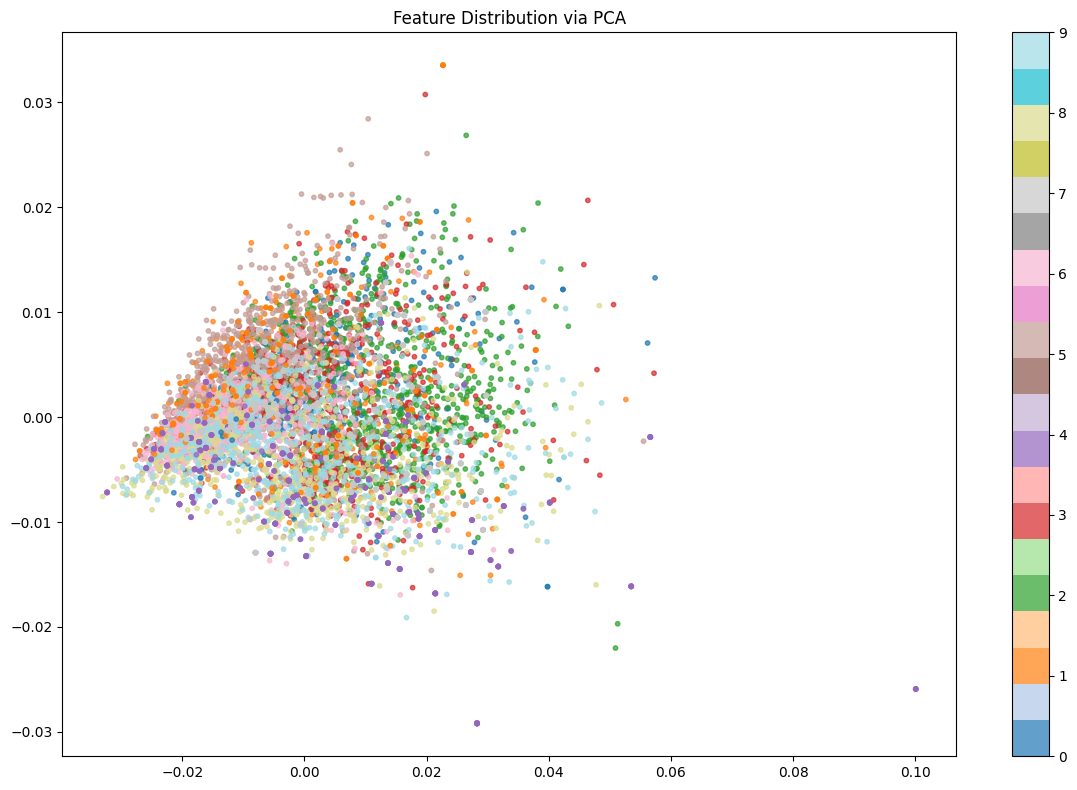

Processing Folds:  60%|██████    | 3/5 [12:37<08:27, 253.68s/it]

✔ Fold 2 Faiss Index and parameters saved to 'image_classification_models\knn_faiss_folds'.

=== Fold 3 ===
[Fold 3] ▶ Original Train: 7450개, Original Test: 1862개
[Fold 3] ▶ Resampled Train: 7450개, Test: 1862개
  ▶ Train feature extraction (Fold 3)...


  Extracting Train Features (Fold 3): 100%|██████████| 7450/7450 [03:29<00:00, 35.57it/s]


  ✔ Train feature extraction complete for Fold 3. Feature Shape: (7450, 2628)
  ✔ Faiss KNN 모델 학습 완료 (Fold 3).
  ▶ Test feature extraction (Fold 3)...


  Extracting Test Features (Fold 3): 100%|██████████| 1862/1862 [00:49<00:00, 37.83it/s]


  ✔ Test feature extraction complete for Fold 3. Feature Shape: (1862, 2628)
  ▶ KNN 예측 중 (Faiss 사용, k=5)...
  ✔ 예측 완료.
[Test Accuracy] 0.4758
               precision    recall  f1-score   support

      Bicycle       0.25      0.30      0.27       160
       Bridge       0.41      0.46      0.43       160
          Bus       0.40      0.48      0.44       242
          Car       0.27      0.27      0.27       200
      Chimney       0.77      0.95      0.85       160
    Crosswalk       0.55      0.46      0.50       248
      Hydrant       0.59      0.48      0.53       190
   Motorcycle       0.72      1.00      0.84       160
         Palm       0.40      0.30      0.34       182
Traffic Light       0.24      0.13      0.17       160

     accuracy                           0.48      1862
    macro avg       0.46      0.48      0.47      1862
 weighted avg       0.46      0.48      0.46      1862



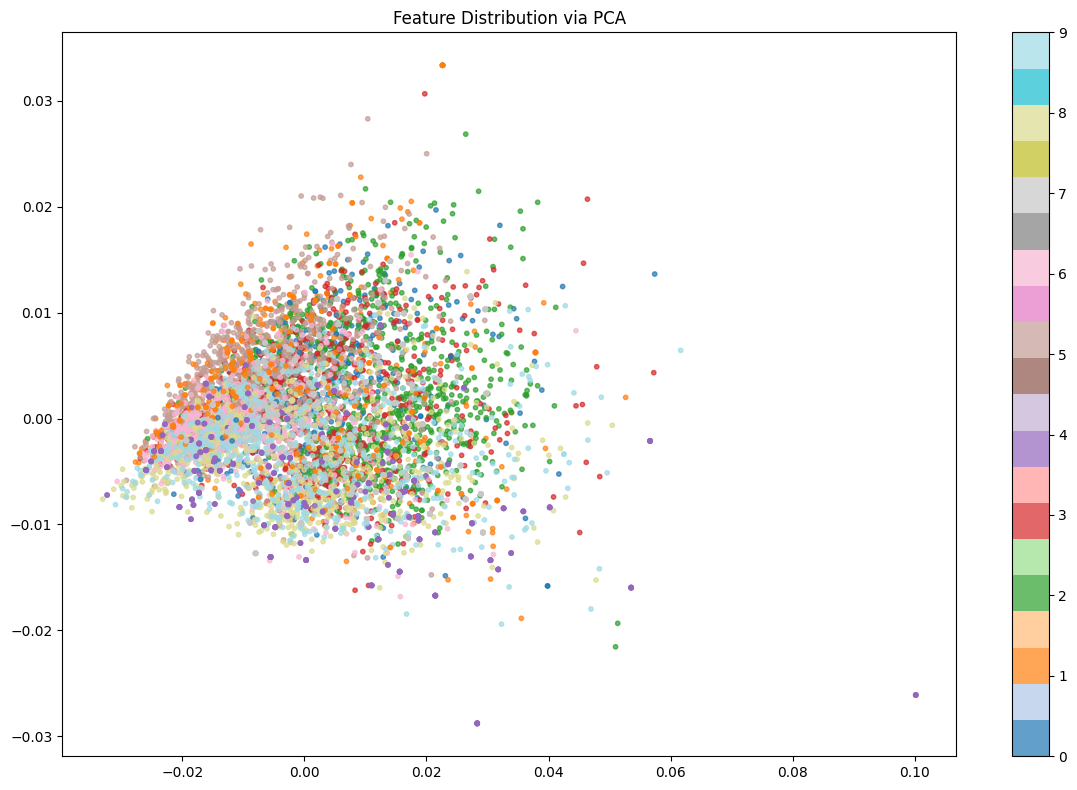

Processing Folds:  80%|████████  | 4/5 [16:58<04:16, 256.32s/it]

✔ Fold 3 Faiss Index and parameters saved to 'image_classification_models\knn_faiss_folds'.

=== Fold 4 ===
[Fold 4] ▶ Original Train: 7450개, Original Test: 1862개
[Fold 4] ▶ Resampled Train: 7450개, Test: 1862개
  ▶ Train feature extraction (Fold 4)...


  Extracting Train Features (Fold 4): 100%|██████████| 7450/7450 [03:26<00:00, 36.06it/s]


  ✔ Train feature extraction complete for Fold 4. Feature Shape: (7450, 2628)
  ✔ Faiss KNN 모델 학습 완료 (Fold 4).
  ▶ Test feature extraction (Fold 4)...


  Extracting Test Features (Fold 4): 100%|██████████| 1862/1862 [00:47<00:00, 39.27it/s]


  ✔ Test feature extraction complete for Fold 4. Feature Shape: (1862, 2628)
  ▶ KNN 예측 중 (Faiss 사용, k=5)...
  ✔ 예측 완료.
[Test Accuracy] 0.4887
               precision    recall  f1-score   support

      Bicycle       0.25      0.33      0.29       160
       Bridge       0.42      0.47      0.44       160
          Bus       0.45      0.48      0.46       241
          Car       0.31      0.29      0.30       200
      Chimney       0.78      0.99      0.87       160
    Crosswalk       0.57      0.47      0.52       248
      Hydrant       0.55      0.53      0.54       191
   Motorcycle       0.72      1.00      0.84       160
         Palm       0.38      0.31      0.34       182
Traffic Light       0.21      0.09      0.13       160

     accuracy                           0.49      1862
    macro avg       0.47      0.50      0.47      1862
 weighted avg       0.47      0.49      0.47      1862



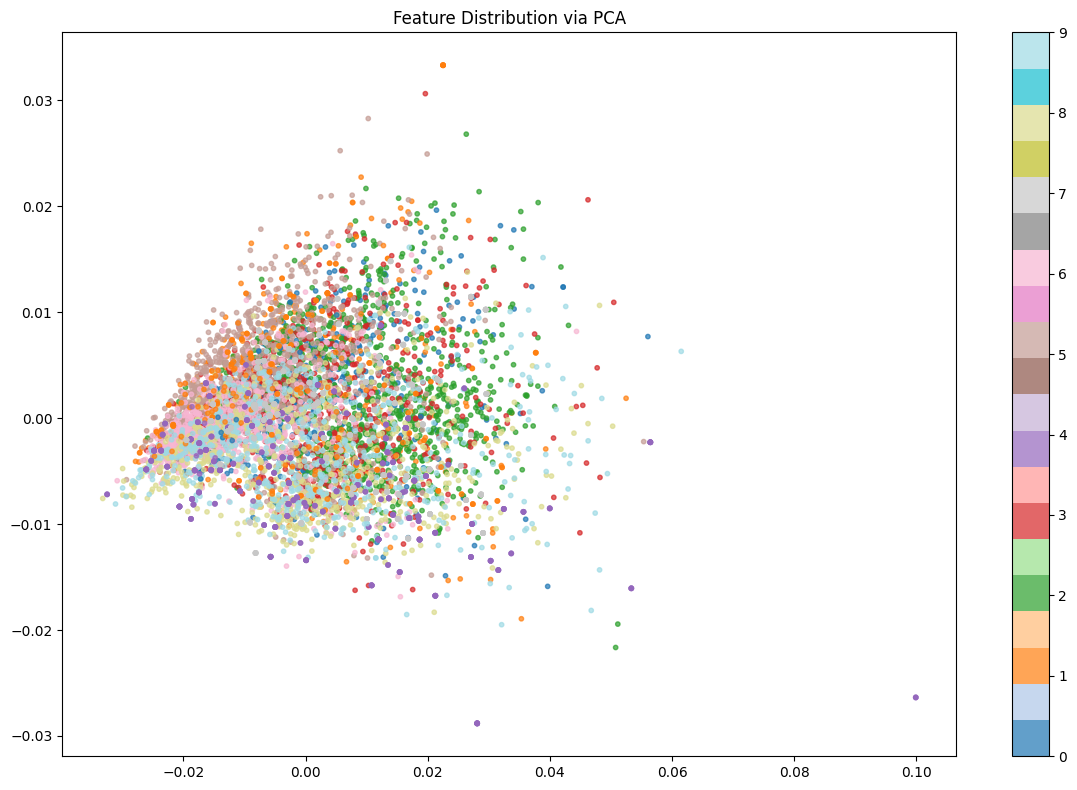

Processing Folds: 100%|██████████| 5/5 [21:14<00:00, 254.81s/it]

✔ Fold 4 Faiss Index and parameters saved to 'image_classification_models\knn_faiss_folds'.

=== 5-Fold CV Average ===
Accuracy : 0.4780 ± 0.0070
Precision: 0.4641 ± 0.0047
Recall   : 0.4780 ± 0.0070
F1-Score : 0.4636 ± 0.0057


In [37]:
# ==============================================================================
#  5-Fold 교차 검증 루프 및 모델 저장
# ==============================================================================
accuracies = []
precisions = []
recalls = []
f1_scores = []

# 모델 저장 경로 설정 (사용자 로컬 PC 내)
# 현재 스크립트가 실행되는 폴더 내에 'image_classification_models' 폴더 생성
MODEL_SAVE_BASE_DIR = 'image_classification_models'
os.makedirs(MODEL_SAVE_BASE_DIR, exist_ok=True)
print(f"모델 저장 기본 경로: {os.path.abspath(MODEL_SAVE_BASE_DIR)}")


print("\n=== 5-Fold 교차 검증 시작 ===")
# 중요한 변경: skf.split은 이제 리샘플링되지 않은 원본 images_df를 기준으로 인덱스를 분할합니다.
for i, (train_index, test_index) in tqdm(enumerate(skf.split(images_df_resampled, images_df_resampled['label_encoded'])), # images_df_resampled -> images_df로 변경
                                         total=skf.get_n_splits(), desc="Processing Folds"):
    # 원본 데이터프레임에서 train/test 데이터 분리
    X_train_original = images_df_resampled.iloc[train_index]['image_data'].values
    y_train_original = images_df_resampled.iloc[train_index]['label_encoded'].values
    X_test_original = images_df_resampled.iloc[test_index]['image_data'].values
    y_test_original = images_df_resampled.iloc[test_index]['label_encoded'].values

    print(f"\n=== Fold {i} ===")
    print(f"[Fold {i}] ▶ Original Train: {len(X_train_original)}개, Original Test: {len(X_test_original)}개")

    X_train_resampled = X_train_original[y_train_original.flatten()]
    
    f = { # 이제 f 딕셔너리는 폴드별 리샘플링된 학습 데이터와 원본 테스트 데이터를 포함
        'fold': i,
        'X_train': X_train_original,
        'y_train': y_train_original,
        'X_test': X_test_original, # 테스트 세트는 원본 유지
        'y_test': y_test_original,
    }
    print(f"[Fold {f['fold']}] ▶ Resampled Train: {len(f['X_train'])}개, Test: {len(f['X_test'])}개")


    # 1) train set에서 feature 추출 (병렬 처리 적용)
    print(f"  ▶ Train feature extraction (Fold {f['fold']})...")
    X_train_feats = thread_map(
        lambda img: 
        extract_features(img, sift_bovw_vocabulary),
        f['X_train'],
        max_workers=8,
        desc=f"  Extracting Train Features (Fold {f['fold']})"
    )
    X_train_feats = np.array(X_train_feats)

    print(f"  ✔ Train feature extraction complete for Fold {f['fold']}. Feature Shape: {X_train_feats.shape}")
    
    # Faiss KNN 모델 학습 (Index 생성)
    faiss_model_tuple = train_faiss_knn_euclidean(
        X_train_feats,
        f['y_train'],
        n_neighbors=5
    )
    print(f"  ✔ Faiss KNN 모델 학습 완료 (Fold {f['fold']}).")

    # 2) test set에서 feature 추출 (병렬 처리 적용)
    print(f"  ▶ Test feature extraction (Fold {f['fold']})...")
    X_test_feats = thread_map(
        lambda img: extract_features(img, sift_bovw_vocabulary),
        f['X_test'],
        max_workers=8,
        desc=f"  Extracting Test Features (Fold {f['fold']})"
    )
    X_test_feats = np.array(X_test_feats)

    print(f"  ✔ Test feature extraction complete for Fold {f['fold']}. Feature Shape: {X_test_feats.shape}")
    
    # 평가
    y_pred = test(
        faiss_model_tuple,
        X_test_feats,
        f['y_test'],
        average='weighted'
    )

    visualize_features(X_train_feats, f['y_train'], method='pca')

    # 폴드별 지표 저장
    acc = accuracy_score(f['y_test'], y_pred)
    prec = precision_score(f['y_test'], y_pred, average='weighted', zero_division=0)
    rec  = recall_score(f['y_test'], y_pred, average='weighted', zero_division=0)
    f1   = f1_score(f['y_test'], y_pred, average='weighted', zero_division=0) # F1-score 추가

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    
    # --- 각 폴드별 Faiss 모델 저장 ---
    fold_model_dir = os.path.join(MODEL_SAVE_BASE_DIR, 'knn_faiss_folds')
    os.makedirs(fold_model_dir, exist_ok=True)
    fold_index_path = os.path.join(fold_model_dir, f'faiss_index_fold_{f["fold"]}.bin')
    
    faiss.write_index(faiss_model_tuple[0], fold_index_path)
    joblib.dump(
        {'y_train_labels': faiss_model_tuple[1], 'n_neighbors': faiss_model_tuple[2]},
        os.path.join(fold_model_dir, f'faiss_params_fold_{f["fold"]}.joblib')
    )
    print(f"✔ Fold {f['fold']} Faiss Index and parameters saved to '{fold_model_dir}'.")
    # --- 저장 부분 끝 ---


# 5) 5-fold 평균 지표 출력
print("\n=== 5-Fold CV Average ===")
print(f"Accuracy : {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall   : {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1-Score : {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}") # F1-score 출력 추가

In [38]:
def test_on_new_dataset(fold_model_dir, X_test_feats, y_test, average='weighted'):
    """
    저장된 5개의 fold별 FAISS 모델을 불러와서 각각 예측하고, 앙상블 결과를 리턴
    - fold_model_dir: 폴드별 모델이 저장된 디렉토리
    - X_test_feats: 새로운 데이터셋의 feature vector (numpy array)
    - y_test: ground truth 라벨
    """
    all_preds = []

    for fold in range(5):
        # 모델 로드
        index_path = os.path.join(fold_model_dir, f'faiss_index_fold_{fold}.bin')
        param_path = os.path.join(fold_model_dir, f'faiss_params_fold_{fold}.joblib')

        faiss_index = faiss.read_index(index_path)
        params = joblib.load(param_path)
        y_train_labels = params['y_train_labels']
        k = params['n_neighbors']

        # 예측 수행
        print(f"\n▶ Fold {fold} 모델 예측 중...")
        y_pred = predict_faiss_knn_euclidean(faiss_index, y_train_labels, k, X_test_feats)
        all_preds.append(y_pred)

    # 다수결 앙상블
    all_preds = np.array(all_preds)  # shape: (n_folds, n_samples)
    final_preds = []
    for i in range(all_preds.shape[1]):
        votes = all_preds[:, i]
        unique_labels, counts = np.unique(votes, return_counts=True)
        final_label = unique_labels[np.argmax(counts)]
        final_preds.append(final_label)
    final_preds = np.array(final_preds)

    # 평가
    print("\n=== 앙상블 평가 결과 ===")
    acc = accuracy_score(y_test, final_preds)
    prec = precision_score(y_test, final_preds, average=average, zero_division=0)
    rec = recall_score(y_test, final_preds, average=average, zero_division=0)
    print(f"[Ensemble Accuracy] {acc:.4f}")
    print(classification_report(y_test, final_preds))  # 클래스 이름 지정은 필요시 추가

    return final_preds, acc, prec, rec

In [39]:
# 1. 데이터 로드
fold_model_dir = 'image_classification_models/knn_faiss_folds'
DATASET_BASE_PATH = "C:/Users/bvb09/.cache/kagglehub/datasets/test/"


print("▶ 이미지 데이터 로드 중...")
try:
    images_df = load_images_from_folder(DATASET_BASE_PATH)
    print(f"✔ 총 {len(images_df)}개의 이미지 로드 완료.")
except FileNotFoundError as e:
    print(f"오류: {e}")
    exit()

label_counts = images_df['label'].value_counts()
top_labels = label_counts.head(10).index  
images_df = images_df[images_df['label'].isin(top_labels)]

images_df = images_df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), 10), random_state=42)
).reset_index(drop=True)
print(f"✔ 상위 라벨에서 최대 10개씩 샘플링 완료. 총 이미지 수: {len(images_df)}")

# 4. 라벨 인코딩
le = LabelEncoder()
images_df['label_encoded'] = le.fit_transform(images_df['label'])
print(f"✔ 라벨 인코딩 완료. 클래스 수: {len(le.classes_)}")

# 5. Feature 추출
print("▶ Feature 추출 중...")
X_test_feats = [
    extract_features(img, sift_bovw_vocabulary)
    for img in tqdm(images_df['image_data'], desc="  Extracting Test Features")
]
X_test_feats = np.array(X_test_feats)
print(f"✔ Feature 추출 완료. Shape: {X_test_feats.shape}")

# 6. 라벨 추출
y_test = images_df['label_encoded'].values

# 7. 앙상블 평가
ensemble_model = EnsembleFaissKNN(fold_model_dir=fold_model_dir)
ensemble_model.load_models()
y_pred = ensemble_model.evaluate(X_test_feats, y_test, le=le)

score = silhouette_score(X_test_feats, y_test)
print("Silhouette Score:", score)


▶ 이미지 데이터 로드 중...


폴더 로드 중: 100%|██████████| 10/10 [00:00<00:00, 362.57it/s]
C:\Users\bvb09\AppData\Local\Temp\ipykernel_31608\3279838565.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  images_df = images_df.groupby('label', group_keys=False).apply(


✔ 총 15개의 이미지 로드 완료.
✔ 상위 라벨에서 최대 10개씩 샘플링 완료. 총 이미지 수: 15
✔ 라벨 인코딩 완료. 클래스 수: 10
▶ Feature 추출 중...


  Extracting Test Features: 100%|██████████| 15/15 [00:00<00:00, 27.07it/s]


✔ Feature 추출 완료. Shape: (15, 2628)
✔ 5개의 Fold 모델 로딩 완료.

=== 앙상블 평가 결과 ===
Accuracy : 0.2667
Precision: 0.2222
Recall   : 0.2667
               precision    recall  f1-score   support

      Bicycle       0.00      0.00      0.00         2
       Bridge       0.00      0.00      0.00         1
          Bus       0.33      0.50      0.40         2
          Car       0.50      0.33      0.40         3
      Chimney       0.00      0.00      0.00         1
    Crosswalk       1.00      1.00      1.00         1
      Hydrant       0.00      0.00      0.00         2
   Motorcycle       0.00      0.00      0.00         1
         Palm       0.17      1.00      0.29         1
Traffic Light       0.00      0.00      0.00         1

     accuracy                           0.27        15
    macro avg       0.20      0.28      0.21        15
 weighted avg       0.22      0.27      0.22        15

Silhouette Score: -0.034645833


c:\Users\bvb09\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bvb09\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bvb09\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

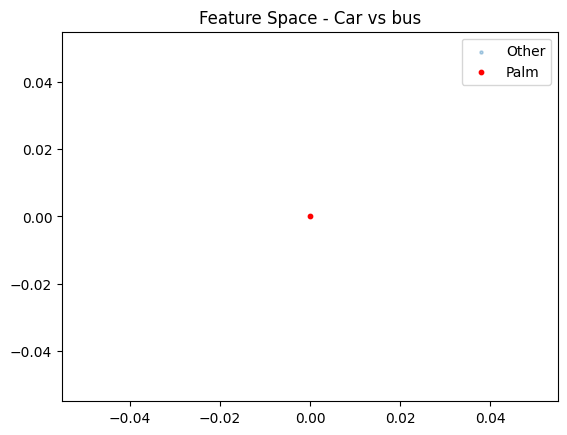

In [40]:
car_indices = np.where(images_df['label'] == 'Palm')[0]
other_indices = np.where(images_df['label'] != 'Palm')[0]

plt.scatter(X_test_feats[other_indices][:, 0], X_test_feats[other_indices][:, 1], alpha=0.3, label='Other', s=5)
plt.scatter(X_test_feats[car_indices][:, 0], X_test_feats[car_indices][:, 1], alpha=1.0, label='Palm', s=10, c='red')
plt.legend()
plt.title("Feature Space - Car vs bus")
plt.show()


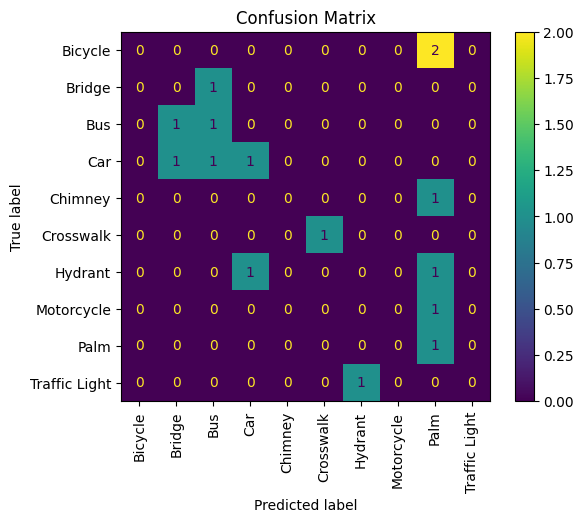

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [42]:
from sklearn.manifold import TSNE

# 시각화 대상 클래스
target_classes = ['Palm', 'Traffic Light']

# 대상 샘플 인덱스 추출
target_indices = images_df[images_df['label'].isin(target_classes)].index

# 대상 feature 및 라벨 추출
subset_feats = X_test_feats[target_indices]
subset_labels = images_df.loc[target_indices, 'label'].values

# t-SNE 변환
tsne = TSNE(n_components=2, perplexity=20, n_iter=500, random_state=42)
subset_feats_2d = tsne.fit_transform(subset_feats)

# 시각화
plt.figure(figsize=(8, 6))
for label in target_classes:
    idx = subset_labels == label
    plt.scatter(subset_feats_2d[idx, 0], subset_feats_2d[idx, 1], label=label, alpha=0.6, s=20)

plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\bvb09\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ValueError: perplexity must be less than n_samples